### Plots for Prediction task

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import f1_score, precision_score, recall_score
import numpy as np
from sklearn.metrics import roc_auc_score

df_results = pd.read_csv("./processed_csvs/classification.csv")
df_results = df_results[df_results["dataset"] == "mimic_mortality_prediction"]

In [8]:
def convert_to_float_list(string_list):
    return [float(x) for x in string_list.strip("[]").split(", ")]


# Apply the function to the 'probabilities' column
df_results["probabilities"] = df_results["probabilities"].apply(convert_to_float_list)
df_results["positive_probabilities"] = [p[1] for p in df_results["probabilities"]]

In [9]:
all_datasets = df_results["dataset"].unique()
all_models = df_results["model"].unique()
all_annotators = df_results["annotator"].unique()
df_results = df_results.sort_values(by=["dataset", "model", "annotator"])
all_auroc = []

df_list = []

for dataset in all_datasets:
    for model in all_models:
        for annotator in all_annotators:
            df = df_results[
                (df_results["dataset"] == dataset)
                & (df_results["model"] == model)
                & (df_results["annotator"] == annotator)
            ].copy()
            labels = df["gold_class"].unique()
            auroc = roc_auc_score(df["gold_class"], df["positive_probabilities"])
            df["auroc"] = auroc
            df_list.append(df)

df_results = pd.concat(df_list)

In [10]:
df_results = df_results.drop(["instance", "probabilities"], axis=1)

df_results_grouped = (
    df_results.groupby(["task_type", "dataset", "model", "annotator"])
    .mean()
    .reset_index()
)

In [11]:
df_results_grouped

,task_type,dataset,model,annotator,id,gold_class,positive_probabilities,auroc
0,classification,mimic_mortality_prediction,Llama-2-13b-chat,Annotator_1,79.5,0.14375,0.047282,0.828785
1,classification,mimic_mortality_prediction,Llama-2-13b-chat,Annotator_10,79.5,0.14375,0.203873,0.808474
2,classification,mimic_mortality_prediction,Llama-2-13b-chat,Annotator_11,79.5,0.14375,0.317938,0.827039
3,classification,mimic_mortality_prediction,Llama-2-13b-chat,Annotator_12,79.5,0.14375,0.839087,0.792606
4,classification,mimic_mortality_prediction,Llama-2-13b-chat,Annotator_2,79.5,0.14375,0.344132,0.741193
...,...,...,...,...,...,...,...,...
79,classification,mimic_mortality_prediction,mistral-7b,Annotator_5,79.5,0.14375,0.269617,0.795620
80,classification,mimic_mortality_prediction,mistral-7b,Annotator_6,79.5,0.14375,0.641857,0.780863
81,classification,mimic_mortality_prediction,mistral-7b,Annotator_7,79.5,0.14375,0.081477,0.796573
82,classification,mimic_mortality_prediction,mistral-7b,Annotator_8,79.5,0.14375,0.212216,0.763567


In [12]:
DATASET_MAP = {
    "mimic_mortality_prediction": "MIMIC Mortality Prediction",
}

MODEL_MAP = {
    "mistral-7b": "Mistral (7b)",
    "Llama-2-7b-chat-hf": "Llama-2 (7b)",
    "asclepius": "Asclepius (7b)",
    "Llama-2-13b-chat": "Llama-2 (13b)",
    "clinical-camel-7b": "Clin-Camel (13b)",
    "alpaca-7b": "Alpaca (7b)",
    "medalpaca-7b": "MedAlpaca (7b)",
}

ORDER_MAP = {
    "Llama-2-7b-chat-hf": 2,
    "Llama-2-13b-chat": 1,
    "alpaca-7b": 3,
    "mistral-7b": 0,
    "asclepius": 6,
    "clinical-camel-7b": 5,
    "medalpaca-7b": 7,
}

df_results_grouped["order"] = df_results_grouped["model"].apply(lambda x: ORDER_MAP[x])

df_results_grouped = df_results_grouped.sort_values(by=["order"])

In [13]:
df_results_grouped = df_results_grouped.rename(columns={"auroc": "AUROC"})

# drop any rows containing -1

df_results_grouped = df_results_grouped[(df_results_grouped["AUROC"] != -1)]

In [14]:
df_results_grouped["y_labels"] = df_results_grouped["model"].apply(
    lambda x: MODEL_MAP[x]
)

In [15]:
df_results

,id,task_type,dataset,model,annotator,gold_class,positive_probabilities,auroc
191856,13,classification,mimic_mortality_prediction,asclepius,Annotator_1,0,0.020332,0.756903
191857,18,classification,mimic_mortality_prediction,asclepius,Annotator_1,0,0.009708,0.756903
191858,19,classification,mimic_mortality_prediction,asclepius,Annotator_1,0,0.015906,0.756903
191859,25,classification,mimic_mortality_prediction,asclepius,Annotator_1,0,0.010987,0.756903
191860,26,classification,mimic_mortality_prediction,asclepius,Annotator_1,0,0.012432,0.756903
...,...,...,...,...,...,...,...,...
205291,152,classification,mimic_mortality_prediction,medalpaca-7b,Annotator_9,0,0.549989,0.670105
205292,153,classification,mimic_mortality_prediction,medalpaca-7b,Annotator_9,0,0.461049,0.670105
205293,155,classification,mimic_mortality_prediction,medalpaca-7b,Annotator_9,0,0.485568,0.670105
205294,156,classification,mimic_mortality_prediction,medalpaca-7b,Annotator_9,0,0.500000,0.670105


In [16]:
colors = sns.color_palette("deep", 10, desat=0.8)
colors

[(0.33725490196078434, 0.45647058823529396, 0.6509803921568628),
 (0.8121568627450981, 0.5329411764705883, 0.3760784313725489),
 (0.36588235294117644, 0.6262745098039216, 0.4254901960784314),
 (0.7223529411764706, 0.35215686274509816, 0.36470588235294116),
 (0.519607843137255, 0.47254901960784323, 0.6764705882352939),
 (0.556470588235294, 0.4717647058823529, 0.39647058823529413),
 (0.823921568627451, 0.5760784313725489, 0.7517647058823529),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.7654901960784315, 0.7058823529411765, 0.4894117647058822),
 (0.43333333333333335, 0.6874509803921568, 0.7627450980392156)]

In [17]:
# sample colors from the crest cmap

colors = sns.color_palette("deep", 10, desat=0.8)
COLOR_MAP = {
    "Mistral (7b)": colors[7],
    "Llama-2 (7b)": colors[1],
    "Llama-2 (13b)": colors[0],
    "Alpaca (7b)": colors[3],
    "Asclepius (7b)": colors[1],
    "Clin-Camel (13b)": colors[0],
    "MedAlpaca (7b)": colors[3],
}

COLOR_MAP_LOWER = {
    "mistral-7b": colors[7],
    "Llama-2-7b-chat-hf": colors[1],
    "Llama-2-13b-chat": colors[0],
    "alpaca-7b": colors[3],
    "asclepius": colors[1],
    "clinical-camel-7b": colors[0],
    "medalpaca-7b": colors[3],
}

/tmp/ipykernel_63387/3845451899.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  mon.set_xticklabels(ticks, size=24)


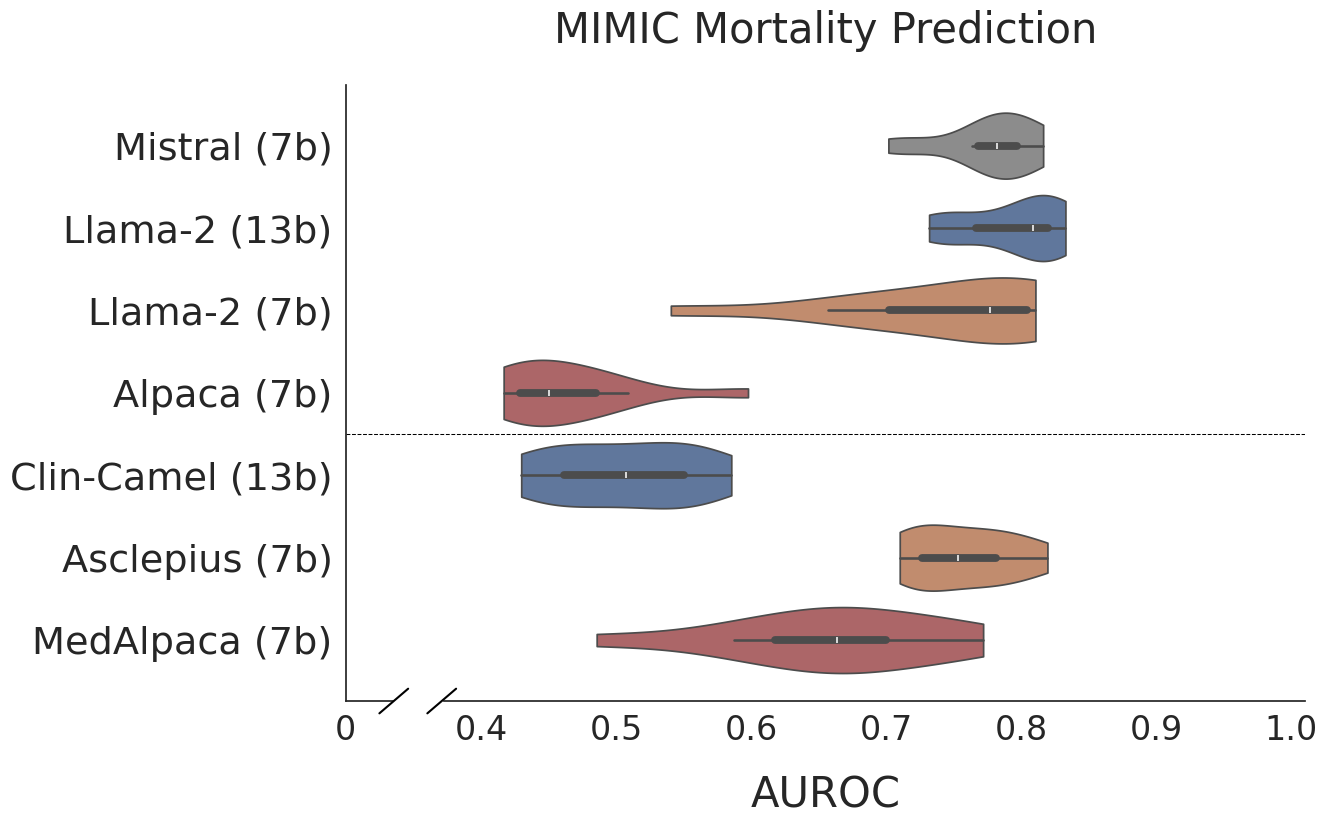

In [18]:
plt.figure(figsize=(14, 9))
sns.set_context("talk")
for dataset in DATASET_MAP.keys():
    # df_results_grouped = df_results_grouped.drop(["task_type", "gold_class", "instance"], axis=1)

    palette = sns.color_palette("crest")
    sns.set_theme(style="white", font_scale=2.5)
    mon = sns.violinplot(
        data=df_results_grouped,
        x="AUROC",
        y="y_labels",
        hue="model",
        palette=COLOR_MAP_LOWER,
        cut=0,
        legend=False,
    )
    mon.set_title("MIMIC Mortality Prediction", pad=30)
    # mon.set("AUROC", pad=20)
    mon.set_xlabel("AUROC", labelpad=20)
    # mon.set_yticklabels(MODEL_MAP.values())
    mon.set(ylabel=None)
    plt.xlim(0.3, 1.01)
    plt.tight_layout()
    sns.despine(top=True, right=True, left=False, bottom=False)
    # place a dotted line between the 4th and 5th in the y axis
    mon.axhline(3.5, color="black", linestyle="--", linewidth=0.75)

    # replace xticks with string versions
    ticks = mon.get_xticks()
    ticks = [f"{x:.1f}" for x in ticks]
    ticks[0] = 0
    mon.set_xticklabels(ticks, size=24)
    d = 0.95  # proportion of vertical to horizontal extent of the slanted line
    # draw a white rectangle
    mon.add_patch(
        plt.Rectangle(
            (0.050, 0),
            0.05,
            0.2,
            fill=True,
            color="white",
            zorder=3,
            transform=mon.transAxes,
            clip_on=False,
        )
    )

    # draw slanted line small
    mon.plot(
        [0.035, 0.065],
        [-0.02, 0.02],
        color="black",
        clip_on=False,
        transform=mon.transAxes,
        zorder=3,
    )
    mon.plot(
        [0.085, 0.115],
        [-0.02, 0.02],
        color="black",
        clip_on=False,
        transform=mon.transAxes,
        zorder=3,
    )
    # mon.text(0.95, 3.85, "Non-Clinical", ha="center", va="center")
    # mon.text(0.95, 3.15, "Clinical", ha="center", va="center")
    plt.savefig(f"prediction_big_order1__.pdf", bbox_inches="tight")

### Demographic eval stuff

In [19]:
import json
import os
import pandas as pd
from datasets import load_from_disk
from task_parser_mapping import get_parser
from tqdm import tqdm
from ipdb import set_trace

# load for demogrpahics
root_path = "/work/frink/private_datasets"

pred_set_path = os.path.join(root_path, "mimic", "inhospital_mortality")
full_path_demo = os.path.join(pred_set_path, "test_subsample_with_demographics_2")
pred_set_with_demo = load_from_disk(full_path_demo)

full_path = os.path.join(pred_set_path, "test_subsample")
pred_set = load_from_disk(full_path)

In [20]:
demo_data = pred_set_with_demo.to_pandas()
demo_data

,text,INHOSP_MORT,__index_level_0__,gender,ethnicity,language,subject_id
0,Note 1\npmicu nursing admission/progress note\...,0,1325,M,BLACK,Missing,22581
1,Note 1\nPATIENT'S WITH WIDE QRS COMPLEX SINCE ...,0,239,M,WHITE,Missing,11890
2,Note 1\nAdmission Note\nActive 85 y.o. man fro...,0,394,M,WHITE,Missing,24013
3,"Note 1\n86 YO F s/p fall at home today, with r...",0,658,F,WHITE,English,70441
4,Note 1\npmicu nursing progress 7p-7a\nreview o...,0,754,M,BLACK,Missing,6262
...,...,...,...,...,...,...,...
155,Note 1\nMICU Brief Admit note:\n80y.o. male tr...,0,703,M,WHITE,Missing,25659
156,Note 1\n[**Hospital Ward Name **] 4 ICU NPN 07...,0,219,M,UNKNOWN/NOT SPECIFIED,English,11753
157,Note 1\nnursing note 1400hrs - 1700hrs\n\n\nad...,0,938,M,BLACK,Missing,7138
158,Note 1\nMicu Nursing Admission Note:\n\n67 yo ...,0,949,F,WHITE,Missing,25811


In [21]:
demo_data = pred_set_with_demo.to_pandas()
demo_data["id"] = demo_data.index
demo_data

,text,INHOSP_MORT,__index_level_0__,gender,ethnicity,language,subject_id,id
0,Note 1\npmicu nursing admission/progress note\...,0,1325,M,BLACK,Missing,22581,0
1,Note 1\nPATIENT'S WITH WIDE QRS COMPLEX SINCE ...,0,239,M,WHITE,Missing,11890,1
2,Note 1\nAdmission Note\nActive 85 y.o. man fro...,0,394,M,WHITE,Missing,24013,2
3,"Note 1\n86 YO F s/p fall at home today, with r...",0,658,F,WHITE,English,70441,3
4,Note 1\npmicu nursing progress 7p-7a\nreview o...,0,754,M,BLACK,Missing,6262,4
...,...,...,...,...,...,...,...,...
155,Note 1\nMICU Brief Admit note:\n80y.o. male tr...,0,703,M,WHITE,Missing,25659,155
156,Note 1\n[**Hospital Ward Name **] 4 ICU NPN 07...,0,219,M,UNKNOWN/NOT SPECIFIED,English,11753,156
157,Note 1\nnursing note 1400hrs - 1700hrs\n\n\nad...,0,938,M,BLACK,Missing,7138,157
158,Note 1\nMicu Nursing Admission Note:\n\n67 yo ...,0,949,F,WHITE,Missing,25811,158


In [22]:
new_df = df_results.merge(demo_data, on="id")
new_df

,id,task_type,dataset,model,annotator,gold_class,positive_probabilities,auroc,text,INHOSP_MORT,__index_level_0__,gender,ethnicity,language,subject_id
0,13,classification,mimic_mortality_prediction,asclepius,Annotator_1,0,0.020332,0.756903,Note 1\nNSG ADMIT NOTE\nSEE FLOWSHEET FOR SPEC...,0,26,F,WHITE,Missing,20699
1,18,classification,mimic_mortality_prediction,asclepius,Annotator_1,0,0.009708,0.756903,Note 1\nCCU progress/admit note 9p-7a\n\n71 yo...,0,966,M,WHITE,English,10774
2,19,classification,mimic_mortality_prediction,asclepius,Annotator_1,0,0.015906,0.756903,Note 1\nMICU NSG ADMISSION\nPT IS AN 89 YO WOM...,0,234,F,BLACK,Missing,3466
3,25,classification,mimic_mortality_prediction,asclepius,Annotator_1,0,0.010987,0.756903,Note 1\nnsg note\nSEE FLOWSHEET FOR SPECIFICS....,0,1233,M,BLACK,Other,20953
4,26,classification,mimic_mortality_prediction,asclepius,Annotator_1,0,0.012432,0.756903,Note 1\n[**Hospital Unit Name **] nursing note...,0,474,M,WHITE,Missing,10633
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13435,152,classification,mimic_mortality_prediction,medalpaca-7b,Annotator_9,0,0.549989,0.670105,Note 1\nGoal:\n -SBP<140\n Subarachnoid he...,0,46,F,ASIAN,English,95427
13436,153,classification,mimic_mortality_prediction,medalpaca-7b,Annotator_9,0,0.461049,0.670105,Note 1\nNSG ADMIT NOTE\n**************\n\nPT I...,0,892,M,OTHER,Missing,1314
13437,155,classification,mimic_mortality_prediction,medalpaca-7b,Annotator_9,0,0.485568,0.670105,Note 1\nMICU Brief Admit note:\n80y.o. male tr...,0,703,M,WHITE,Missing,25659
13438,156,classification,mimic_mortality_prediction,medalpaca-7b,Annotator_9,0,0.500000,0.670105,Note 1\n[**Hospital Ward Name **] 4 ICU NPN 07...,0,219,M,UNKNOWN/NOT SPECIFIED,English,11753


model_annotator_f1_scores_df = df_results\
    .groupby(["model", "annotator"])\
    .apply(lambda x: f1_score(x["gold_class"], x["pred"], average="macro", zero_division=np.nan), include_groups=False)\
    .reset_index()\
    .rename(columns={0: "f1_score"})\
    .groupby(["model"])\
    .apply(lambda x: x.sort_values(by="f1_score"), include_groups=False)\
    .reset_index()\
    .drop("level_1", axis=1)

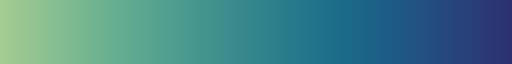

In [23]:
sns.color_palette("crest", as_cmap=True)

### Race

In [24]:
new_df["ethnicity_binary"] = (new_df["ethnicity"] == "WHITE").map(
    {True: "White", False: "Non-White"}
)

f1_score_binary_ethnicity_df = (
    new_df.groupby(["model", "annotator", "ethnicity_binary"])
    .apply(
        lambda x: roc_auc_score(x["gold_class"], x["positive_probabilities"]),
        include_groups=False,
    )
    .reset_index()
    .rename(columns={0: "AUROC"})
)

In [25]:
model_annotator_f1_scores_df = df_results_grouped

asclepius
        model     annotator ethnicity_binary     AUROC  AUROC_overall
6   asclepius  Annotator_12        Non-White  0.619048       0.710092
7   asclepius  Annotator_12            White  0.760855       0.710092
19  asclepius   Annotator_7            White  0.768092       0.713107
18  asclepius   Annotator_7        Non-White  0.600340       0.713107
4   asclepius  Annotator_11        Non-White  0.431973       0.718819
5   asclepius  Annotator_11            White  0.844079       0.718819
8   asclepius   Annotator_2        Non-White  0.636054       0.728658
9   asclepius   Annotator_2            White  0.771711       0.728658
12  asclepius   Annotator_4        Non-White  0.530612       0.737226
13  asclepius   Annotator_4            White  0.849671       0.737226
2   asclepius  Annotator_10        Non-White  0.574830       0.748810
3   asclepius  Annotator_10            White  0.855592       0.748810
0   asclepius   Annotator_1        Non-White  0.520408       0.756903
1   asclep

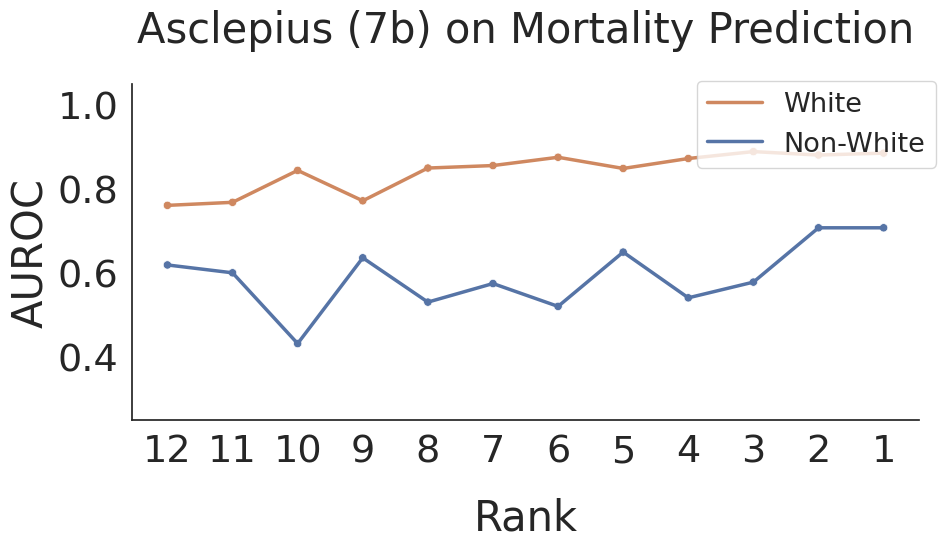

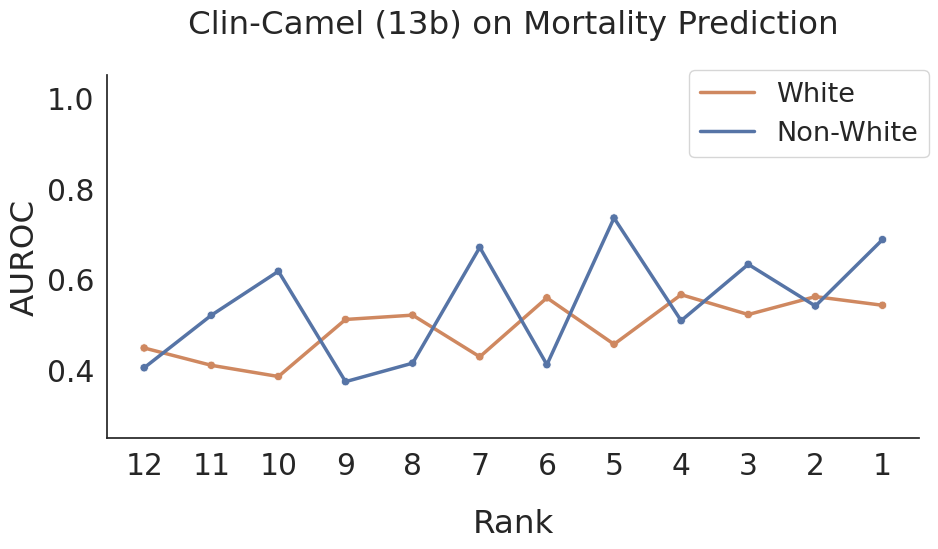

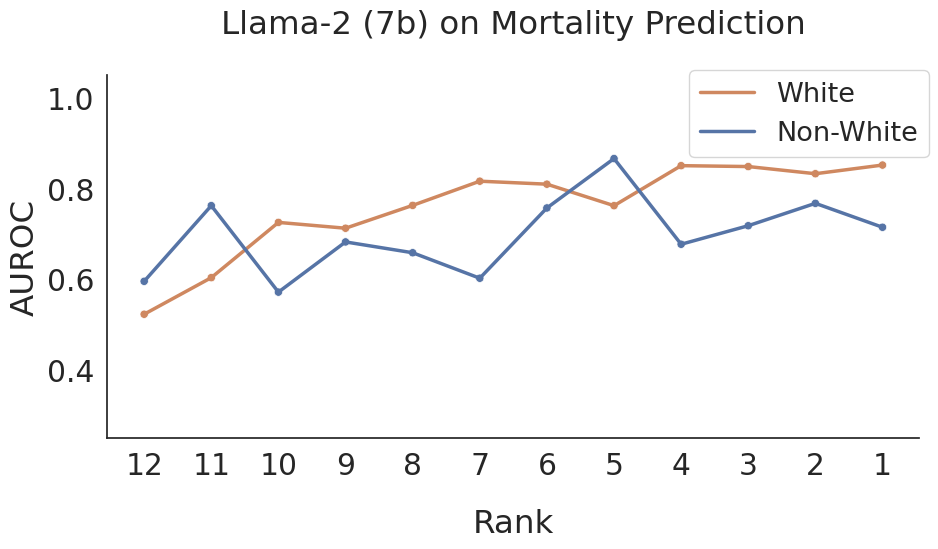

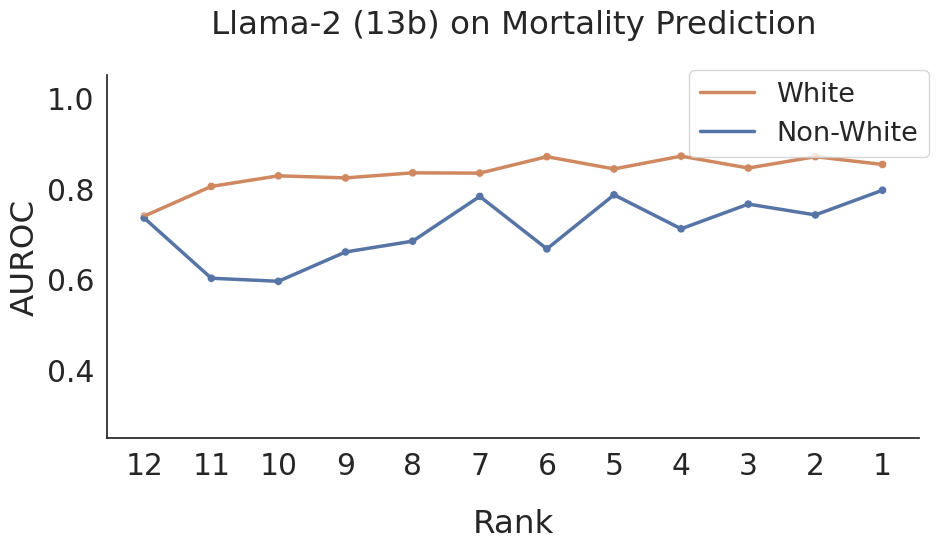

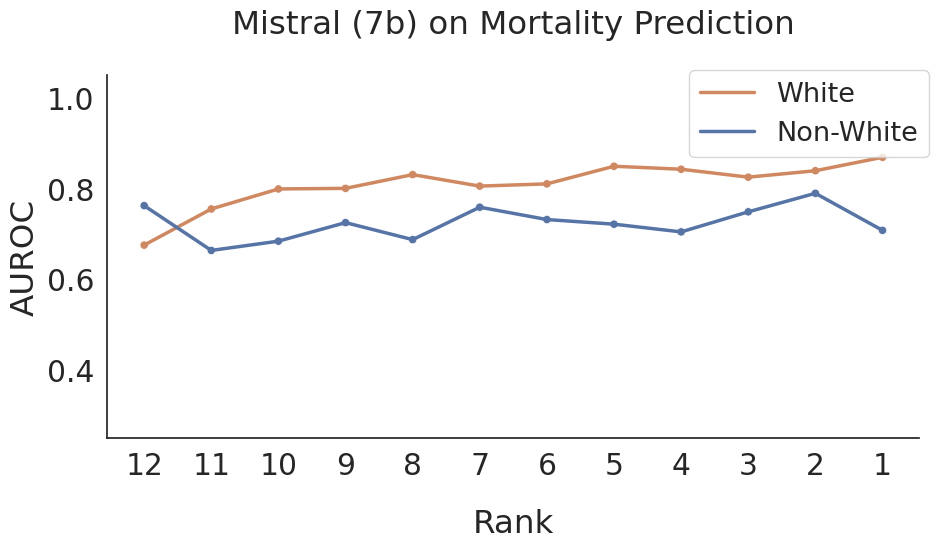

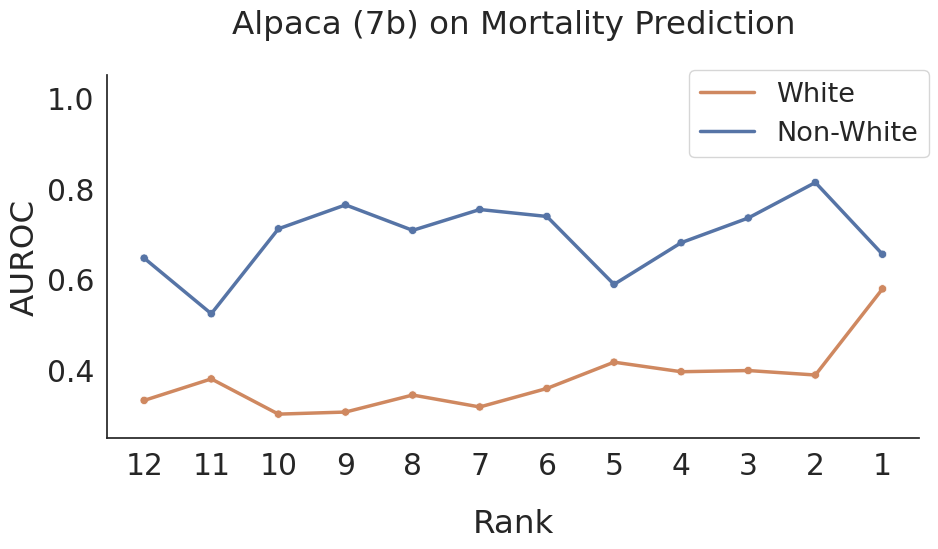

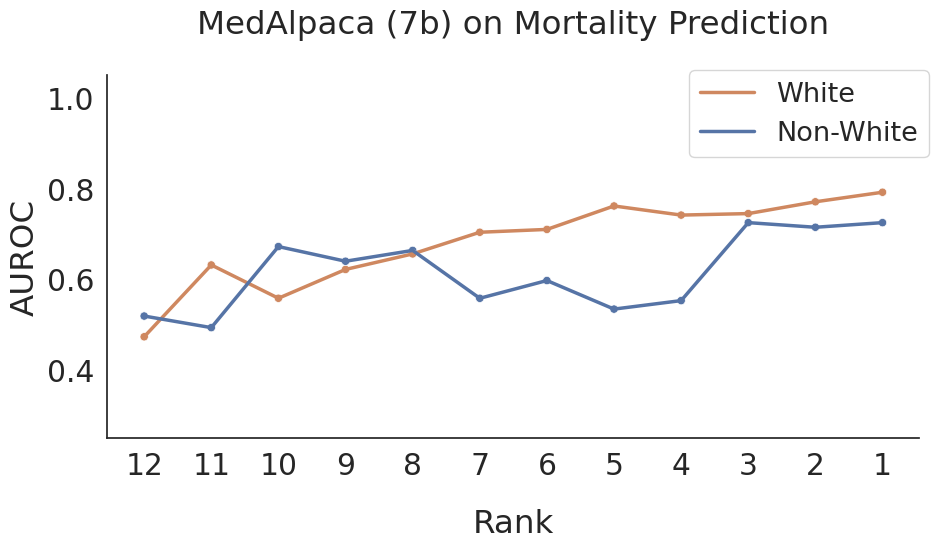

In [26]:
# loop for model
colors = sns.color_palette("deep", 10, desat=0.8)

all_models = df_results["model"].unique()
pallete_dict = {"White": colors[1], "Non-White": colors[0]}

for model in all_models:
    sample_data = f1_score_binary_ethnicity_df[
        f1_score_binary_ethnicity_df["model"] == model
    ].copy()
    sample_order = model_annotator_f1_scores_df[
        model_annotator_f1_scores_df["model"] == model
    ].copy()

    sample_data = (
        sample_data.merge(
            sample_order[["annotator", "AUROC"]], how="left", on="annotator"
        )
        .rename(columns={"AUROC_x": "AUROC", "AUROC_y": "AUROC_overall"})
        .sort_values(by="AUROC_overall")
    )

    plt.figure(figsize=(10, 6))

    mon = sns.lineplot(
        data=sample_data,
        x="annotator",
        y="AUROC",
        hue="ethnicity_binary",
        linewidth=2.5,
        hue_order=pallete_dict.keys(),
        palette=pallete_dict,
    )
    print(model)
    print(sample_data)
    # sns.legend(fontsize=10)
    mon.set_xticks(range(12))
    mon.set_xticklabels(["12", "11", "10", "9", "8", "7", "6", "5", "4", "3", "2", "1"])
    mon.set(xlabel=None)
    mon.set(ylabel=None)
    mon.set_xlabel("Rank", labelpad=20)

    mon.legend(title="Ethnicity", loc="upper left", fontsize=10, title_fontsize=10)
    sm = sns.scatterplot(
        data=sample_data,
        x="annotator",
        y="AUROC",
        hue="ethnicity_binary",
        legend=False,
        palette=pallete_dict,
    )
    plt.ylim(0.25, 1.05)
    # sm.set(xlabel="Rank")
    sm.set(ylabel="AUROC")
    sm.set_title(f"{MODEL_MAP[model]} on Mortality Prediction", pad=30)
    sns.set_theme(style="white", font_scale=1.95)
    sns.despine(top=True, right=True, left=False, bottom=False)
    plt.legend(
        bbox_to_anchor=(0.7, 1.05),
        # bbox_to_anchor=(1, 1),
        loc="upper left",
        fontsize="small",
        title_fontsize="small",
    )
    plt.tight_layout()

    # no legend
    # plt.legend([], [], frameon=False)
    plt.savefig(f"race_{model}.pdf", bbox_inches="tight")
    # no legend

    # put legend outside of the figure frame -right-

### Sex

In [27]:
GENDER_MAP = {"M": "Male", "F": "Female"}

f1_score_binary_sex_df = (
    new_df.groupby(["model", "annotator", "gender"])
    .apply(
        lambda x: roc_auc_score(x["gold_class"], x["positive_probabilities"]),
        include_groups=False,
    )
    .reset_index()
    .rename(columns={0: "AUROC"})
)

f1_score_binary_sex_df["gender_full"] = f1_score_binary_sex_df["gender"].apply(
    lambda x: GENDER_MAP[x]
)

In [28]:
all_models = df_results["model"].unique()
print(all_models)

['asclepius' 'clinical-camel-7b' 'Llama-2-7b-chat-hf' 'Llama-2-13b-chat'
 'mistral-7b' 'alpaca-7b' 'medalpaca-7b']


asclepius
        model     annotator gender     AUROC gender_full  AUROC_overall
6   asclepius  Annotator_12      F  0.740537      Female       0.710092
7   asclepius  Annotator_12      M  0.680405        Male       0.710092
19  asclepius   Annotator_7      M  0.806081        Male       0.713107
18  asclepius   Annotator_7      F  0.617216      Female       0.713107
4   asclepius  Annotator_11      F  0.665446      Female       0.718819
5   asclepius  Annotator_11      M  0.768919        Male       0.718819
8   asclepius   Annotator_2      F  0.734432      Female       0.728658
9   asclepius   Annotator_2      M  0.734459        Male       0.728658
12  asclepius   Annotator_4      F  0.706960      Female       0.737226
13  asclepius   Annotator_4      M  0.775676        Male       0.737226
2   asclepius  Annotator_10      F  0.659341      Female       0.748810
3   asclepius  Annotator_10      M  0.833108        Male       0.748810
0   asclepius   Annotator_1      F  0.740537      Fema

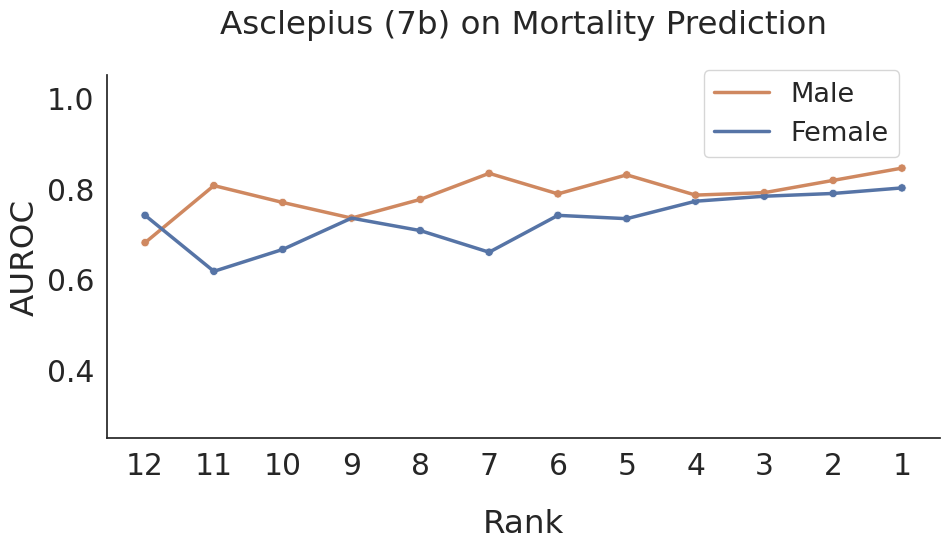

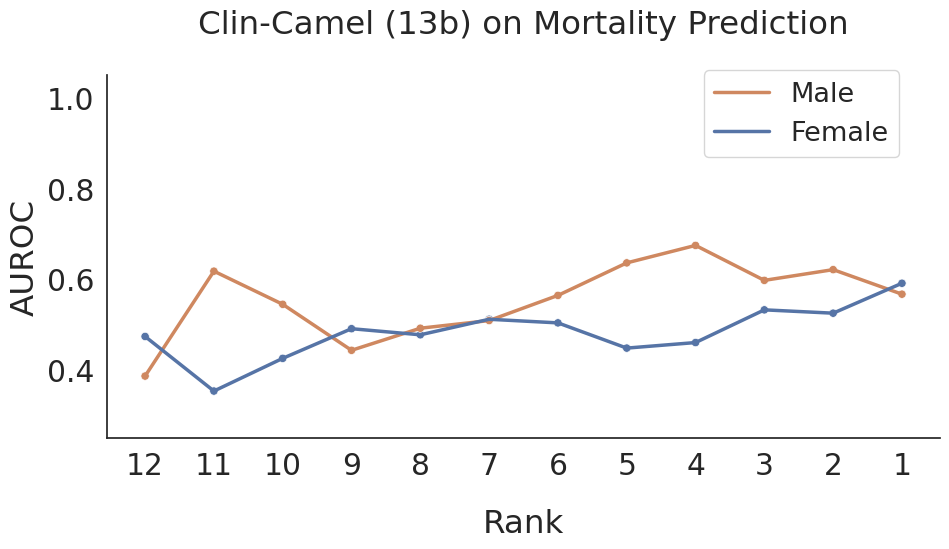

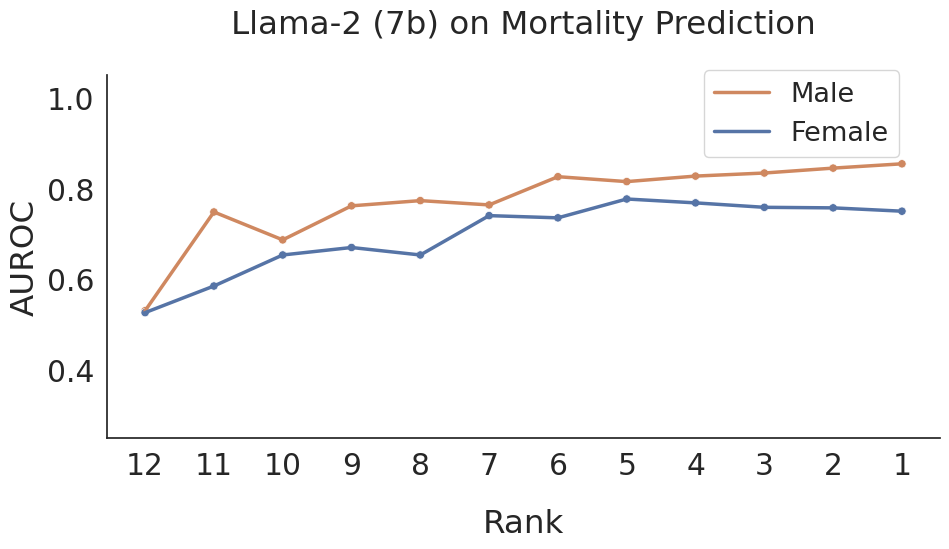

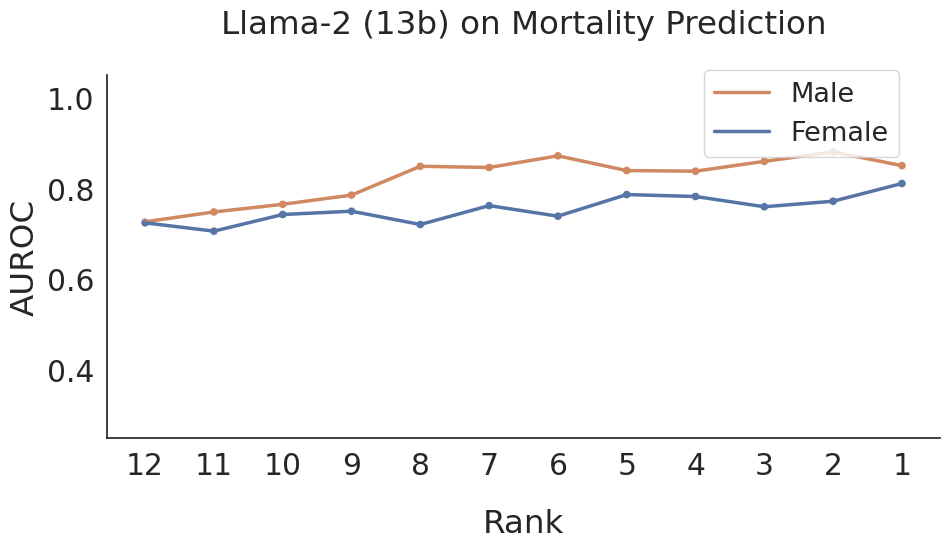

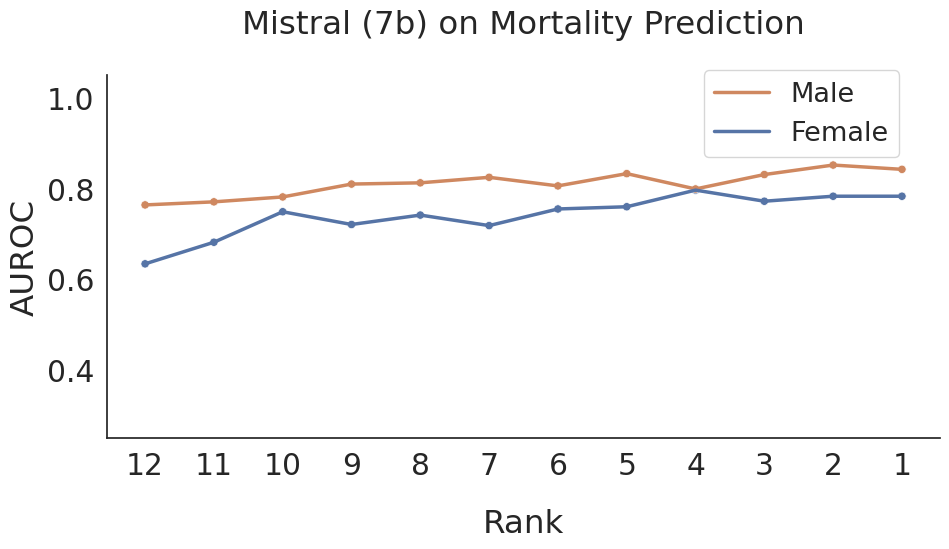

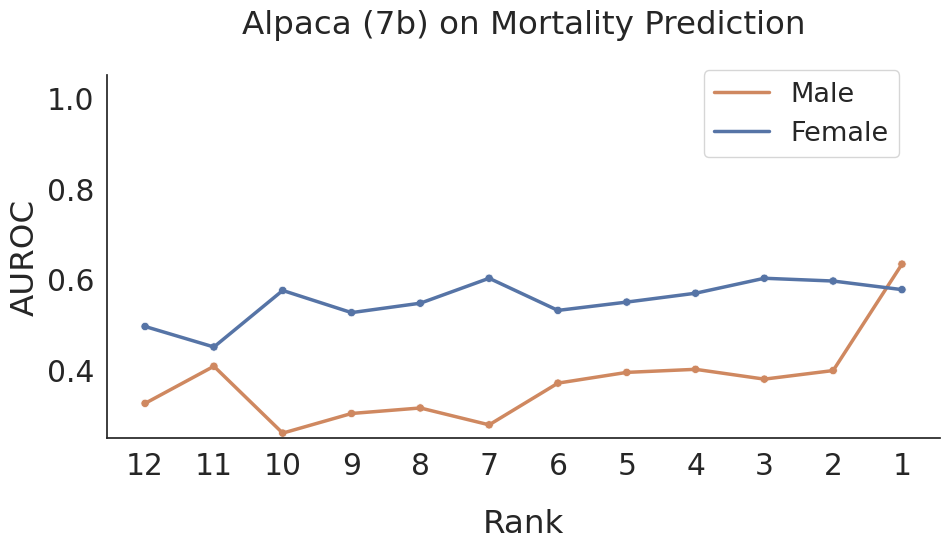

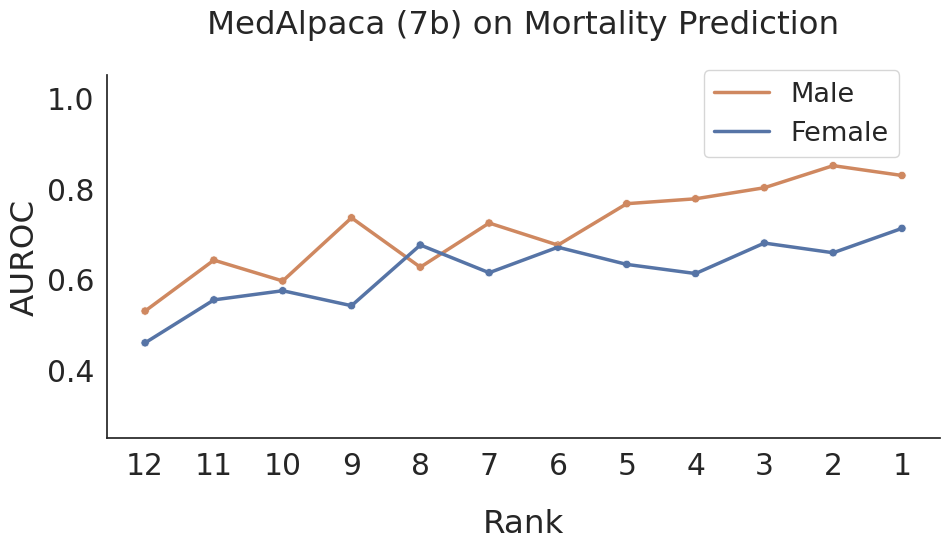

In [29]:
all_models = [
    "clinical-camel-7b",
    "Llama-2-7b-chat-hf",
    "Llama-2-13b-chat",
    "mistral-7b",
    "alpaca-7b",
    "medalpaca-7b",
    "asclepius",
]
colors = sns.color_palette("deep", 10, desat=0.8)

all_models = df_results["model"].unique()
pallete_dict = {"Male": colors[1], "Female": colors[0]}

for model in all_models:
    sample_data = f1_score_binary_sex_df[
        f1_score_binary_ethnicity_df["model"] == model
    ].copy()
    sample_order = model_annotator_f1_scores_df[
        model_annotator_f1_scores_df["model"] == model
    ].copy()

    sample_data = (
        sample_data.merge(
            sample_order[["annotator", "AUROC"]], how="left", on="annotator"
        )
        .rename(columns={"AUROC_x": "AUROC", "AUROC_y": "AUROC_overall"})
        .sort_values(by="AUROC_overall")
    )

    plt.figure(figsize=(10, 6))
    mon = sns.lineplot(
        data=sample_data,
        x="annotator",
        y="AUROC",
        hue="gender_full",
        linewidth=2.5,
        hue_order=pallete_dict.keys(),
        palette=pallete_dict,
    )
    print(model)
    print(sample_data)
    mon.set_xticks(range(12))
    mon.set_xticklabels(["12", "11", "10", "9", "8", "7", "6", "5", "4", "3", "2", "1"])
    mon.set(xlabel=None)
    mon.set(ylabel=None)
    plt.legend(title="Sex", loc="upper left", fontsize=10, title_fontsize=10)
    mon.set_xlabel("Rank", labelpad=20)

    sm = sns.scatterplot(
        data=sample_data,
        x="annotator",
        y="AUROC",
        hue="gender_full",
        legend=False,
        palette=pallete_dict,
    )
    sm.set(ylabel="AUROC")
    sm.set_title(f"{MODEL_MAP[model]} on Mortality Prediction", pad=30)
    sns.set_theme(style="white", font_scale=1.95)
    sns.despine(top=True, right=True, left=False, bottom=False)
    plt.legend(
        bbox_to_anchor=(0.7, 1.05),
        # bbox_to_anchor=(1, 1),
        loc="upper left",
        fontsize="small",
        title_fontsize="small",
    )

    # plt.legend([], [], frameon=False)
    plt.ylim(0.25, 1.05)
    plt.tight_layout()
    plt.savefig(f"sex_{model}.pdf", bbox_inches="tight")